In [1]:
import numpy as np
import pandas as pd
from copy import deepcopy
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

### Device 세팅

In [2]:
device = 'mps' if torch.backends.mps.is_available() else 'cpu'

torch.manual_seed(1)
if device == 'mps':
    torch.mps.manual_seed(1)

print(device)

mps


### 모델 및 학습 정의

In [3]:
DROP_OUT_R = 0.5
LEARNING_RATE = 0.001

EPOCHS = 500
BATCH_SIZE = 50
Seq_length = 5
#VALIDATION_RATE = 0.2

CHECK_INTERVAL = 10
# EARLY_STOP = 30

In [4]:
class AttentionLSTM_use_VIT(nn.Module):
    def __init__(self):
        super().__init__()

        self.LSTM_layer = nn.LSTM(input_size=30,
                                hidden_size = 30,
                                num_layers = 1,
                                batch_first=True)
        
        self.MA_layer = nn.MultiheadAttention(
            embed_dim = 30,
            num_heads = 5,
            batch_first=True,
            dropout = DROP_OUT_R
        )

        self.FC_layer1 = nn.Linear(30, 1)
        self.FC_layer2 = nn.Linear(5, 1)
    
    def forward(self, input_x):
        lstm_y,_ = self.LSTM_layer(input_x)
        ma_y,_ = self.MA_layer(lstm_y, lstm_y, lstm_y)
        fc_y1 = self.FC_layer1(ma_y)
        fc_y2 = self.FC_layer2(fc_y1.reshape(-1,5))

        return fc_y2

MC_AttentionLSTM = AttentionLSTM_use_VIT().to(device)

In [5]:
# 파라미터 개수 확인
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(count_parameters(MC_AttentionLSTM)) #사용

11197


In [6]:
loss_func = nn.MSELoss()
optimizer = optim.Adam(MC_AttentionLSTM.parameters(), lr=LEARNING_RATE)

### 학습 과정 정의

In [7]:
train_losses = []

In [8]:
def train_model(train_loader, epochs, check_interval):
    
    for e in range(epochs):
        train_loss = 0
        
        MC_AttentionLSTM.train()
        for x_batch, y_batch in train_loader:

            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            
            pred_y = MC_AttentionLSTM(x_batch)
            loss = loss_func(pred_y, y_batch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()    
            
            train_loss += loss.item()

        train_loss = train_loss/len(train_loader)
        train_losses.append(train_loss)
        
        if (e % check_interval) == 0:
            print("epoch : ", e, "train loss: ",train_losses[-1])

### Custom Dataset Type 정의

### Custom Dataset Type 정의

In [9]:
class BAT_DATASET(Dataset):
    def __init__(self, X, y):
        super().__init__()
        X = deepcopy(X)
        y = deepcopy(y)
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.X)
    

    def __getitem__(self, index):
        rX = self.X[index]
        ry = self.y[index]

        return rX, ry
        

### Multi channel LSTM 데이터 준비 (Seq_length = 5(i ~ i+5사이클로 i+6사이클 예측할 예정) , input_feature = 30(한 cycle당 30개 데이터 사용))

In [10]:
def prepareXY_forLSTM(X_ndArray, y_ndArray, Seq_length):
   X_ndArray = X_ndArray.reshape(-1,30)
   X_data = []
   for idx in range(0, X_ndArray.shape[0]):
      if (idx+1)-Seq_length < 0:
         tmp = np.zeros((Seq_length-(idx+1), 30))
         tmp = np.concatenate((tmp, X_ndArray[0:idx+1]), axis=0)
         X_data.append(tmp)
      else:
         X_data.append(X_ndArray[(idx+1)-Seq_length:idx+1])
      
   X_data = np.array(X_data)

   return X_data, y_ndArray

### ----- ⚠️ 파라미터 불러오기 ------------------------

params = torch.load("../BEST_MODEL/MC_LSTM_params.pt")
LSTM.load_state_dict(params)

### ----- B0006/B0007/B00018 데이터 학습 ------

In [11]:
X_scaler = MinMaxScaler(feature_range=(0,1))
y_scaler = MinMaxScaler(feature_range=(0,1))

def all_data_train_wrapper():
    data_file_indices = ["B0005", "B0006", "B0018"]

    for d_idx in data_file_indices: 
        
        x_df = pd.read_csv(f"../Data/DataFrame/{d_idx}_charge_df.csv").loc[:,["cycle", "voltage_measured", "current_measured", "temperature_measured", "time"]]
        y_df = pd.read_csv(f"../Data/DataFrame/{d_idx}_capacity_df.csv").loc[:,["capacity"]]

        x_df_10points = pd.DataFrame(columns=x_df.columns)

        for cyc in x_df["cycle"].unique():
            tmp_cycle_x_df = x_df[x_df["cycle"] == cyc]
            interval = len(tmp_cycle_x_df.index)//10
            choosed_idx = []
            for idx in range(0,len(tmp_cycle_x_df), interval):
                if len(choosed_idx) == 10 :
                        break
                choosed_idx.append(idx)

            x_df_10points = pd.concat([x_df_10points, tmp_cycle_x_df.iloc[choosed_idx]], axis=0)

        
        display(x_df_10points)

        RAW_XDATA = deepcopy(x_df_10points)
        RAW_yDATA = deepcopy(y_df)

        if data_file_indices.index(d_idx) == 0 :
            X_scaled = X_scaler.fit_transform(RAW_XDATA[["voltage_measured", "current_measured", "temperature_measured"]].values.reshape(-1,3))
            y_scaled = y_scaler.fit_transform(RAW_yDATA["capacity"].unique().reshape(-1,1))
        else:
            X_scaled = X_scaler.transform(RAW_XDATA[["voltage_measured", "current_measured", "temperature_measured"]].values.reshape(-1,3))
            y_scaled = y_scaler.transform(RAW_yDATA["capacity"].unique().reshape(-1,1))

        X_data, y_data= prepareXY_forLSTM(X_scaled, y_scaled, Seq_length)
        X_data = torch.from_numpy(X_data).type(torch.float)
        y_data = torch.from_numpy(y_data).type(torch.float)

        train_dataset = BAT_DATASET(X_data, y_data)

        train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle=False)
        
        train_model(train_loader, EPOCHS, CHECK_INTERVAL)

In [12]:
all_data_train_wrapper()

,cycle,voltage_measured,current_measured,temperature_measured,time
0,2,3.434644,1.508670,29.334717,5.500
76,2,3.814079,1.510073,27.739727,234.078
152,2,3.881686,1.509227,26.890304,511.156
228,2,3.937241,1.508747,26.481944,875.062
304,2,3.979605,1.506559,26.476934,1364.266
...,...,...,...,...,...
375596,169,4.205285,0.409958,26.151950,3460.406
375852,169,4.205106,0.261199,25.147212,4206.797
376108,169,4.204985,0.184375,24.550544,4952.406
376364,169,4.206357,0.135819,24.199547,5697.531


epoch :  0 train loss:  0.7036105096340179
epoch :  10 train loss:  0.14597252756357193
epoch :  20 train loss:  0.1197987636551261
epoch :  30 train loss:  0.039647131925448775
epoch :  40 train loss:  0.041353375650942326
epoch :  50 train loss:  0.031295662629418075
epoch :  60 train loss:  0.03144242975395173
epoch :  70 train loss:  0.021862804715055972
epoch :  80 train loss:  0.01913089252775535
epoch :  90 train loss:  0.017100331402616575
epoch :  100 train loss:  0.014195786323398352
epoch :  110 train loss:  0.012812180677428842
epoch :  120 train loss:  0.010580348025541753
epoch :  130 train loss:  0.01245632825884968
epoch :  140 train loss:  0.00988552556373179
epoch :  150 train loss:  0.008316890307469293
epoch :  160 train loss:  0.004736393457278609
epoch :  170 train loss:  0.005210030154557899
epoch :  180 train loss:  0.008303551468998194
epoch :  190 train loss:  0.005840639350935817
epoch :  200 train loss:  0.005781206913525239
epoch :  210 train loss:  0.00517

,cycle,voltage_measured,current_measured,temperature_measured,time
0,2,3.320249,1.515595,31.861155,5.500
76,2,3.772765,1.513079,29.518580,234.078
152,2,3.869867,1.512962,28.012962,511.156
228,2,3.928052,1.515339,27.151827,875.062
304,2,3.968767,1.513685,26.699932,1364.266
...,...,...,...,...,...
375596,169,4.198806,0.349829,25.757573,3460.406
375852,169,4.199172,0.246677,24.935181,4206.797
376108,169,4.199734,0.176216,24.455348,4952.406
376364,169,4.199159,0.129508,24.188771,5697.531


epoch :  0 train loss:  0.018055364256724715
epoch :  10 train loss:  0.008915178012102842
epoch :  20 train loss:  0.0072905076667666435
epoch :  30 train loss:  0.008027456351555884
epoch :  40 train loss:  0.008196046808734536
epoch :  50 train loss:  0.007084522629156709
epoch :  60 train loss:  0.008271710481494665
epoch :  70 train loss:  0.008588515920564532
epoch :  80 train loss:  0.007237925776280463
epoch :  90 train loss:  0.00615474593359977
epoch :  100 train loss:  0.004057785088662058
epoch :  110 train loss:  0.0052642879309132695
epoch :  120 train loss:  0.00630458421073854
epoch :  130 train loss:  0.005817877186927944
epoch :  140 train loss:  0.005478420818690211
epoch :  150 train loss:  0.0052673418540507555
epoch :  160 train loss:  0.005948255711700767
epoch :  170 train loss:  0.005854176473803818
epoch :  180 train loss:  0.005233181931544095
epoch :  190 train loss:  0.007262924336828291
epoch :  200 train loss:  0.006536438246257603
epoch :  210 train loss

,cycle,voltage_measured,current_measured,temperature_measured,time
0,2,3.479525,1.515638,24.286875,5.219
257,2,3.938450,1.516332,24.243205,653.547
514,2,3.997673,1.515629,25.168382,1303.219
771,2,4.049742,1.515579,26.206501,1952.907
1028,2,4.124331,1.517625,27.305446,2602.360
...,...,...,...,...,...
190602,134,4.198443,0.425873,25.797876,3527.000
190702,134,4.198810,0.274652,24.716367,4252.766
190802,134,4.200036,0.192107,24.088869,4977.859
190902,134,4.199606,0.136557,23.701478,5706.000


epoch :  0 train loss:  0.011414618231356144
epoch :  10 train loss:  0.00279628939460963
epoch :  20 train loss:  0.0026659374901403985
epoch :  30 train loss:  0.0025764268551332257
epoch :  40 train loss:  0.002955479120525221
epoch :  50 train loss:  0.002231820758121709
epoch :  60 train loss:  0.002755085122771561
epoch :  70 train loss:  0.0021785597782582045
epoch :  80 train loss:  0.001991418558948984
epoch :  90 train loss:  0.002424520906060934
epoch :  100 train loss:  0.002546340382347504
epoch :  110 train loss:  0.0022299623427291713
epoch :  120 train loss:  0.001926129839072625
epoch :  130 train loss:  0.0019913532693559923
epoch :  140 train loss:  0.0020506704847017923
epoch :  150 train loss:  0.0016972196366017063
epoch :  160 train loss:  0.0019954633510982
epoch :  170 train loss:  0.0018860870429004233
epoch :  180 train loss:  0.0018815621345614393
epoch :  190 train loss:  0.0019090957551573713
epoch :  200 train loss:  0.0018472144341406722
epoch :  210 tra

### ----- ⚠️ 새로운 파라미터 저장 ------------------------

MC_LSTM_params = MC_LSTM.state_dict()
torch.save(MC_LSTM_params, "../BEST_MODEL/MC_LSTM_params.pt")

### B0005 예측

In [13]:
x_df = pd.read_csv(f"../Data/DataFrame/B0007_charge_df.csv").loc[:,["cycle", "voltage_measured", "current_measured", "temperature_measured", "time"]]
y_df = pd.read_csv(f"../Data/DataFrame/B0007_capacity_df.csv").loc[:,["capacity"]]

x_df_10points = pd.DataFrame(columns=x_df.columns)
for cyc in x_df["cycle"].unique():
    tmp_cycle_x_df = x_df[x_df["cycle"] == cyc]
    interval = len(tmp_cycle_x_df.index)//10
    choosed_idx = []
    for idx in range(0,len(tmp_cycle_x_df), interval):
        if len(choosed_idx) == 10 :
            break
        choosed_idx.append(idx)

    x_df_10points = pd.concat([x_df_10points, tmp_cycle_x_df.iloc[choosed_idx]], axis=0)    
display(x_df_10points)

RAW_XDATA = deepcopy(x_df_10points)
RAW_yDATA = deepcopy(y_df)

X_scaled = X_scaler.transform(RAW_XDATA[["voltage_measured", "current_measured", "temperature_measured"]].values.reshape(-1,3))
y_scaled = y_scaler.transform(RAW_yDATA["capacity"].unique().reshape(-1,1))
        
X_data, y_data= prepareXY_forLSTM(X_scaled, y_scaled,Seq_length)
X_data = torch.from_numpy(X_data).type(torch.float)
y_data = torch.from_numpy(y_data).type(torch.float)

test_dataset = BAT_DATASET(X_data, y_data)

test_loader = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle=False)

predicts = []

MC_AttentionLSTM.eval()
with torch.no_grad():
    for x_batch, y_batch in test_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
            
        pred_y = MC_AttentionLSTM(x_batch)

        predicts.append(pred_y.to('cpu'))

predicts_concat = torch.cat(predicts, 0)
predicts_df = pd.DataFrame(y_scaler.inverse_transform(np.array(predicts_concat)))


,cycle,voltage_measured,current_measured,temperature_measured,time
0,2,3.270404,1.491025,30.573112,5.500
76,2,3.785553,1.491617,28.583428,234.078
152,2,3.881019,1.490421,27.391036,511.156
228,2,3.937696,1.491074,26.781612,875.062
304,2,3.978918,1.490915,26.575697,1364.266
...,...,...,...,...,...
375596,169,4.211561,0.512472,26.321016,3460.406
375852,169,4.212398,0.330517,25.159387,4206.797
376108,169,4.213197,0.224771,24.448661,4952.406
376364,169,4.211974,0.149447,24.056267,5697.531


In [14]:
predicts_df

,0
0,1.856394
1,1.880688
2,1.904959
3,1.940131
4,1.994050
...,...
162,1.488734
163,1.486731
164,1.483929
165,1.479773


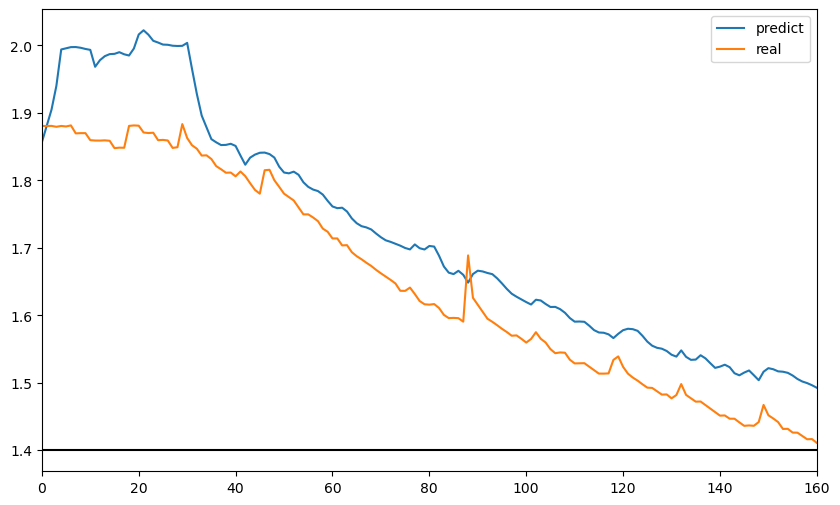

In [15]:
import matplotlib
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [10, 6]
plt.xlim([0, 160])

plt.plot(predicts_df.index, predicts_df.iloc[:,0], label='predict')
plt.plot(range(len(y_df.index)), y_df.iloc[:,0], label='real')
plt.plot(range(len(y_df.index)), [1.4 for i in range(len(y_df.index))], color='black')

plt.legend()
plt.show()

In [16]:
predicts_df.to_csv("./MC_AttentionLSTM.csv", index = False)

In [17]:
from sklearn.metrics import mean_squared_error

RMSE = mean_squared_error(y_df.values.reshape(-1), predicts_df.loc[:,0].values.reshape(-1)) ** 0.5

RMSE

0.07719909675599665

In [18]:
from sklearn.metrics import mean_absolute_percentage_error

MAPE = mean_absolute_percentage_error(y_df.values.reshape(-1), predicts_df.loc[:,0].values.reshape(-1))

MAPE

0.04297794600546493